In [1]:
#!/usr/bin/python

import numpy as np
import pyfits
import os
from matplotlib import pyplot as plt
import delta_r_utils as utils
import environment_utils as envutils

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib import rc, rcParams

inf = np.inf

# Make use of TeX
rc('text',usetex=True)

# Change all fonts to 'Computer Modern'
rc('font',**{'family':'serif','serif':['Computer Modern']})


centering = 'BCG'
envnames = ['Void', 'Sheet', 'Filament', 'Knot']
envcolors = ['red', 'green', 'blue', 'orange']

path_gamacats = '/data2/brouwer/MergedCatalogues'
gamacatname = '%s/GAMACatalogue_1.0.fits'%path_gamacats
shuffledcatname = '%s/shuffled_environment_S4_deltaR.fits'%path_gamacats
path_results = 'results'

rankmin = -999
rankmax = inf

shuffled = True

In [2]:
# Importing GAMA catalogue
print 'Importing GAMA catalogue:', gamacatname
gamacat = pyfits.open(gamacatname)[1].data
shuffledcat = pyfits.open(shuffledcatname)[1].data

galIDlist = gamacat['ID']

# Importing angular seperation
angseplist = gamacat['AngSep%s'%centering]
angseplist[angseplist<=0] = 0.

# Importing and correcting log(Mstar)
logmstarlist = gamacat['logmstar']
fluxscalelist = gamacat['fluxscale'] # Fluxscale, needed for stellar mass correction
corr_list = np.log10(fluxscalelist)# - 2*np.log10(h/0.7)
logmstarlist = logmstarlist + corr_list
ranklist = gamacat['rankBCG']
nQlist = gamacat['nQ']
zlist =  gamacat['Z']


if not shuffled:
    # Importing the real environment
    envlist = gamacat['envS4']
else:
    # Importing the shuffled environment
    envlist = shuffledcat['shuffenvR4']

# Applying a mask to the galaxies
obsmask = (fluxscalelist<500)&(logmstarlist>5) & (0 <= envlist)&(envlist < 4) & \
                                                    (rankmin <= ranklist)&(ranklist < rankmax) & (nQlist >= 3.)

#obsmask = (fluxscalelist<500)&(logmstarlist>5) & (rankmin <= ranklist)&
#obsmask = (0.039 < zlist)&(zlist <= 0.263)
#obsmask = (0 <= gamacat['envS4'])&(gamacat['envS4'] < 4)

logmstarlist = logmstarlist[obsmask]
mstarlist = 10**logmstarlist
angseplist = angseplist[obsmask]

zlist = gamacat['Z'][obsmask]
ranklist = gamacat['rank%s'%centering][obsmask]
envlist = envlist[obsmask]
    
print 'Imported: %i of %i galaxies (%g percent)'%(len(logmstarlist), len(galIDlist), \
                                    float(len(logmstarlist))/float(len(galIDlist))*100.)

Importing GAMA catalogue: /data2/brouwer/MergedCatalogues/GAMACatalogue_1.0.fits
Imported: 112884 of 180960 galaxies (62.3806 percent)


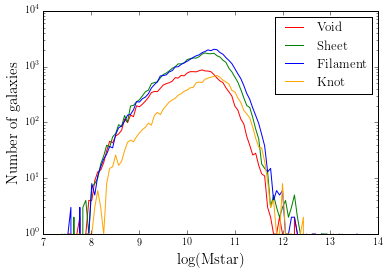

In [3]:
# Creating the log(Mstar) histogram (needed for the mstarweight)

nbins = 100
logmstarbins, logmstarhists, logmstarhistcens = \
envutils.create_histogram('log(Mstar)', logmstarlist, nbins, envnames, envlist, 'lin', False, False, False)

print 

In [6]:
# Calculate the logmstar weight for each galaxy

# Create the average histogram
avhist = np.mean(logmstarhists, 0)

# Calculate the weight for each logmstar bin
weighthists = avhist/logmstarhists
weighthists[np.logical_not(np.isfinite(weighthists))] = 0

weightlist = np.zeros(len(logmstarlist)) # Length of the merged GAMA catalog

for env in xrange(len(envnames)): # For each environment
    envname = envnames[env]
    envmask = (envlist == env) # Mask the lenses outside that environment
    for b in xrange(nbins): # For each logmstar bin
        binmask = (logmstarbins[b]<=logmstarlist) & (logmstarlist<logmstarbins[b+1]) # Mask the lenses outside that bin
        totmask = envmask & binmask
        weight = weighthists[env,b]
        #print 'Env: %s, Bin: %i, Weight: %g'%(envname, b, weight)
        weightlist[totmask] = weight

/software/local/lib64/python2.7/site-packages/ipython-3.2.0-py2.7.egg/IPython/kernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/software/local/lib64/python2.7/site-packages/ipython-3.2.0-py2.7.egg/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


In [7]:
# Print the logmstarweight to a fits file
weightlist_tot = np.zeros(len(galIDlist))
weightlist_tot[obsmask] = weightlist


filename = '%s/mstarweight_rank%g-%g.fits'%(path_results, rankmin, rankmax)
if shuffled:
    filename = filename.replace('.fits', '_shuffled.fits')

envutils.write_catalog(filename, galIDlist, ['mstarweight'], [weightlist_tot])


Old catalog overwritten: results/mstarweight_rank-999-inf_shuffled.fits



environment_utils.py:290: PyfitsDeprecationWarning: The new_table function is deprecated as of version 3.3 and may be removed in a future version.

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.
  tbhdu = pyfits.new_table(cols)


The weights are: [ 1.38761468  1.51196172  1.0982906  ...,  1.38761468  1.23826979
  1.23826979]
The weights are: [ 0.75705716  0.72512563  0.75286195 ...,  0.72512563  0.67626263
  0.72491039]
The weights are: [ 0.68245911  0.64658635  0.65923237 ...,  0.74223602  0.60876058
  0.68245911]
The weights are: [ 2.78865979  1.76479076  2.78865979 ...,  1.96749226  2.08333333
  2.12570888]


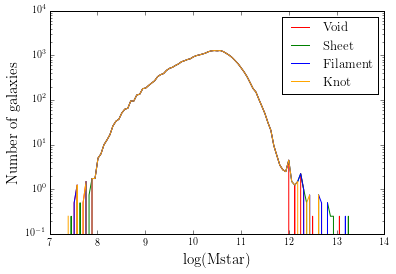

In [8]:
logmstarbins, logmstarhists, logmstarhistcens = envutils.create_histogram('log(Mstar)',logmstarlist, nbins, envnames, envlist, 'lin', False, weightlist, False)

In [9]:



# Repeating AngSep and average quantity calculations for weighted galaxies

In [10]:
# Calculating average redshift, log(M*) and satellite fraction of the lens samples (needed for halo model)

if shuffled:
    print 'For the shuffled environments:'
else:
    print 'For the cosmic environments:'
print 

print 'Without logmstarweight:'
zaverage, mstaraverage, fsat, fsatmax = envutils.calc_halomodel_input(envnames, envlist, ranklist, zlist, mstarlist, False)


print
print 'With logmstarweight:'
zaverage, mstaraverage, fsat, fsatmax = envutils.calc_halomodel_input(envnames, envlist, ranklist, zlist, mstarlist, weightlist)

For the shuffled environments:

Without logmstarweight:
               ['Void', 'Sheet', 'Filament', 'Knot']
average(Z): 0.159521996975,0.165390580893,0.166777178645,0.165173202753,
average(M*): 25895071744.0,33926490112.0,40478826496.0,44991950848.0,
minimum fsat: 0.173857996556,0.249624337648,0.349859883596,0.48424260443,
maximum fsat: 0.901600324116,0.868241372947,0.849225168259,0.842426044299,

With logmstarweight:
               ['Void', 'Sheet', 'Filament', 'Knot']
average(Z): 0.1674028337,0.166378349066,0.163898274302,0.159512385726,
average(M*): 34986696704.0,35495923712.0,35476135936.0,34989006848.0,
minimum fsat: 0.165505215448,0.247523098454,0.353879461123,0.492886851943,
maximum fsat: 0.878623249921,0.862163944871,0.860620980893,0.867156721055,


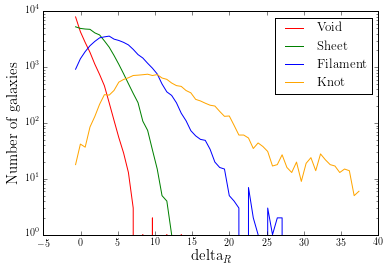

Written: ESD profile plot: environment_deltaR_histogram_shuffled.pdf


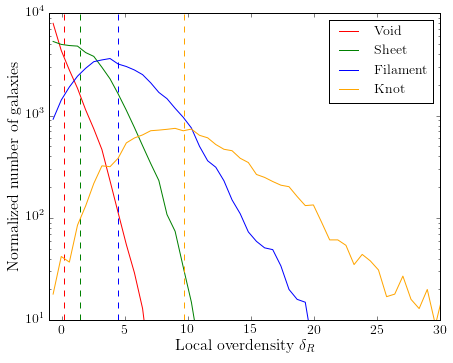

In [43]:
# Plot delta_R

deltacatname = '%s/delta_r_catalog.fits'%path_gamacats
deltacat = pyfits.open(deltacatname)[1].data

deltaRlist = deltacat['delta_R4'][obsmask]

nbins = 60
deltaRbins, deltaRhists, deltaRhistcens = \
envutils.create_histogram('delta_R', deltaRlist, nbins, envnames, envlist, 'lin', False, False, False)

plt.show()
plt.close()

###############################

# Show results
plt.figure(1, figsize=(7, 5.5))


for env in xrange(len(envnames)):
    plt.plot(deltaRhistcens, deltaRhists[env], '', ls='-', color=envcolors[env], label=envnames[env])
    plt.axvline(x = np.median(deltaRlist[envlist==env]), linestyle='--', color=envcolors[env])
    
plt.xlim(-1, 30)
plt.ylim(1e1, 1e4)

plt.yscale('log')
plt.legend(loc='upper right', fontsize=14)

xlabel = 'Local overdensity $\delta_{\r R}$'
#ylabel = 'Number of galaxies'
ylabel = 'Normalized number of galaxies'


plt.ylabel(r'%s'%ylabel,fontsize=16)
plt.xlabel(r'%s'%xlabel,fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

histname = 'environment_deltaR_histogram'
if shuffled:
    histname = '%s_shuffled'%(histname)

plotname = '%s.pdf'%histname

plt.savefig(plotname, format='pdf', bbox_inches='tight')
print 'Written: ESD profile plot:', plotname
   
plt.show()

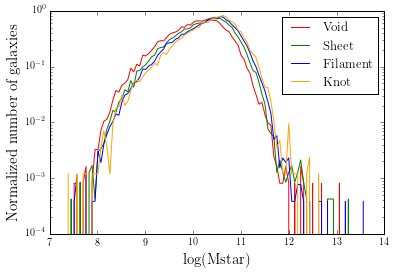

Written: ESD profile plot: environment_logmstar_histogram_shuffled.pdf


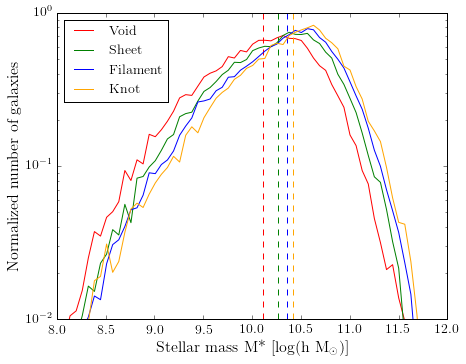

In [48]:
# Creating the log(Mstar) histogram (needed for the mstarweight)

nbins = 100
logmstarbins, logmstarhists, logmstarhistcens = \
envutils.create_histogram('log(Mstar)', logmstarlist, nbins, envnames, envlist, 'lin', 1, False, False)

plt.show()
plt.close()

#####################

# Show results
plt.figure(1, figsize=(7, 5.5))
#plt.plot(logmstarhistcens, avhist, '', ls='-', color='black', label='Average')

for env in xrange(len(envnames)):
    plt.plot(logmstarhistcens, logmstarhists[env], '', ls='-', color=envcolors[env], label=envnames[env])
    plt.axvline(x = np.median(logmstarlist[envlist==env]), linestyle='--', color=envcolors[env])
    
plt.xlim(8, 12)
plt.ylim(1e-2, 1e0)

plt.yscale('log')
plt.legend(loc='upper left', fontsize=14)

xlabel = 'Stellar mass M* [log(h M$_\odot$)]'
#ylabel = 'Number of galaxies'
ylabel = 'Normalized number of galaxies'


plt.ylabel(r'%s'%ylabel,fontsize=16)
plt.xlabel(r'%s'%xlabel,fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

histname = 'environment_logmstar_histogram'
if shuffled:
    histname = '%s_shuffled'%(histname)

plotname = '%s.pdf'%histname

plt.savefig(plotname, format='pdf', bbox_inches='tight')
print 'Written: ESD profile plot:', plotname
   
plt.show()
